In [3]:
import numpy as np
import geopandas
from shapely.geometry import Point, LineString
from shapely.geometry import asPoint
from numpy import asarray

path_to_data = geopandas.datasets.get_path("nybb")
gdf = geopandas.read_file(path_to_data)

gdf

BoroCode       BoroName     Shape_Leng    Shape_Area  \
0         5  Staten Island  330470.010332  1.623820e+09   
1         4         Queens  896344.047763  3.045213e+09   
2         3       Brooklyn  741080.523166  1.937479e+09   
3         1      Manhattan  359299.096471  6.364715e+08   
4         2          Bronx  464392.991824  1.186925e+09   

                                            geometry  
0  MULTIPOLYGON (((970217.022 145643.332, 970227....  
1  MULTIPOLYGON (((1029606.077 156073.814, 102957...  
2  MULTIPOLYGON (((1021176.479 151374.797, 102100...  
3  MULTIPOLYGON (((981219.056 188655.316, 980940....  
4  MULTIPOLYGON (((1012821.806 229228.265, 101278...

In [4]:
def lonlat2UTM(lonlat):  # lonlat is [long, lat]
    utm = (np.floor((lonlat[0] + 180) / 6) % 60) + 1
    if(lonlat[1] > 0): 
        utm = utm + 32600
    else:
        utm = utm + 32700
    return int(utm)

def rotation(r):
    return np.asarray([np.cos(r), -np.sin(r), np.sin(r), np.cos(r)]).reshape(2, 2)

In [5]:
lonlat = [-71,42]
#(np.floor((lonlat[0] + 180) / 6) % 60) + 1
lonlat2UTM(lonlat)

32619

In [6]:
gdf.to_file("my_file.geojson", driver="GeoJSON")

In [7]:
gdf = gdf.set_index("BoroName")
gdf["area"] = gdf.area
gdf["area"]

BoroName
Staten Island    1.623822e+09
Queens           3.045214e+09
Brooklyn         1.937478e+09
Manhattan        6.364712e+08
Bronx            1.186926e+09
Name: area, dtype: float64

In [8]:
gdf['boundary'] = gdf.boundary
gdf['boundary']

BoroName
Staten Island    MULTILINESTRING ((970217.022 145643.332, 97022...
Queens           MULTILINESTRING ((1029606.077 156073.814, 1029...
Brooklyn         MULTILINESTRING ((1021176.479 151374.797, 1021...
Manhattan        MULTILINESTRING ((981219.056 188655.316, 98094...
Bronx            MULTILINESTRING ((1012821.806 229228.265, 1012...
Name: boundary, dtype: geometry

In [9]:
gdf['centroid'] = gdf.centroid
gdf['centroid']

BoroName
Staten Island     POINT (941639.450 150931.991)
Queens           POINT (1034578.078 197116.604)
Brooklyn          POINT (998769.115 174169.761)
Manhattan         POINT (993336.965 222451.437)
Bronx            POINT (1021174.790 249937.980)
Name: centroid, dtype: geometry

In [10]:
first_point = gdf['centroid'].iloc[0]
gdf['distance'] = gdf['centroid'].distance(first_point)
gdf['distance']

BoroName
Staten Island         0.000000
Queens           103781.535276
Brooklyn          61674.893421
Manhattan         88247.742789
Bronx            126996.283623
Name: distance, dtype: float64

<AxesSubplot:>

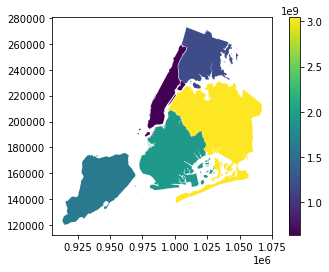

In [11]:
gdf.plot("area", legend=True)

<AxesSubplot:>

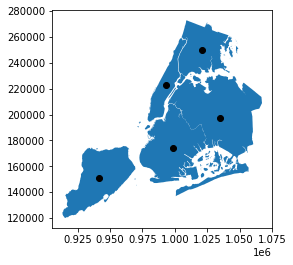

In [12]:
ax = gdf["geometry"].plot()
gdf["centroid"].plot(ax=ax, color="black")



In [13]:
gdf = gdf.set_geometry("geometry")

In [14]:
gdf["convex_hull"] = gdf.convex_hull

<AxesSubplot:>

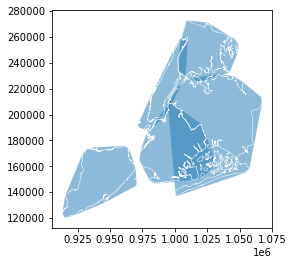

In [15]:
ax = gdf["convex_hull"].plot(alpha=.5)  # saving the first plot as an axis and setting alpha (transparency) to 0.5
gdf["boundary"].plot(ax=ax, color="white", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

In [16]:
# buffering the active geometry by 10 000 feet (geometry is already in feet)
gdf["buffered"] = gdf.buffer(10000)

# buffering the centroid geometry by 10 000 feet (geometry is already in feet)
gdf["buffered_centroid"] = gdf["centroid"].buffer(10000)

<AxesSubplot:>

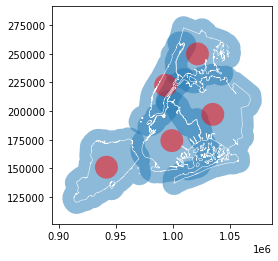

In [17]:
ax = gdf["buffered"].plot(alpha=.5)  # saving the first plot as an axis and setting alpha (transparency) to 0.5
gdf["buffered_centroid"].plot(ax=ax, color="red", alpha=.5)  # passing the first plot as an axis to the second
gdf["boundary"].plot(ax=ax, color="white", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

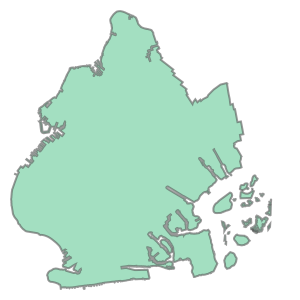

In [18]:
brooklyn = gdf.loc["Brooklyn", "geometry"]
brooklyn

In [19]:
gdf["buffered"].intersects(brooklyn)

BoroName
Staten Island     True
Queens            True
Brooklyn          True
Manhattan         True
Bronx            False
dtype: bool

In [20]:
gdf["within"] = gdf["buffered_centroid"].within(gdf)
gdf["within"]

BoroName
Staten Island     True
Queens            True
Brooklyn         False
Manhattan        False
Bronx            False
Name: within, dtype: bool

<AxesSubplot:>

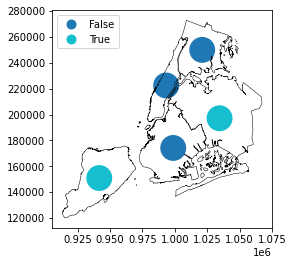

In [21]:
gdf = gdf.set_geometry("buffered_centroid")
ax = gdf.plot("within", legend=True, categorical=True, legend_kwds={'loc': "upper left"})  # using categorical plot and setting the position of the legend
gdf["boundary"].plot(ax=ax, color="black", linewidth=.5)  # passing the first plot and setting linewitdth to 0.5

In [22]:
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

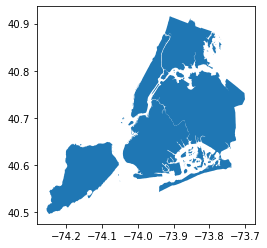

In [23]:
gdf = gdf.set_geometry("geometry")
boroughs_4326 = gdf.to_crs("EPSG:4326")
boroughs_4326.plot()

In [24]:
boroughs_4326.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [25]:
from shapely.geometry import Point, LineString

s = geopandas.GeoSeries([Point(1, 1), Point(2, 2), Point(3, 3)])
s

0    POINT (1.00000 1.00000)
1    POINT (2.00000 2.00000)
2    POINT (3.00000 3.00000)
dtype: geometry

In [26]:
s = geopandas.GeoSeries(

    [Point(1, 1), Point(2, 2), Point(3, 3)], crs="EPSG:3857"  
    #3857 is a Spherical Mercator projection used in google maps and others. It is not what we will use.

)
s


0    POINT (1.00000 1.00000)
1    POINT (2.00000 2.00000)
2    POINT (3.00000 3.00000)
dtype: geometry

In [27]:
s.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [28]:
p = s.to_crs("EPSG:4326")
p.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
# some test points
### NOTE: geoPandas uses x (long), y (lat) order, so no lat/long, only long/lat   ###
q = geopandas.GeoSeries([Point( -71.388964, 42.432612), 
                         Point(-71.383299, 42.432369), 
                         Point(-71.383430, 42.433331)], crs="EPSG:4326" )
#4326 is a Geodetic coordinate system for the world. It is what GPS uses for the lat long values
# and what we need to use as the coordinate system for the input GNSS values.


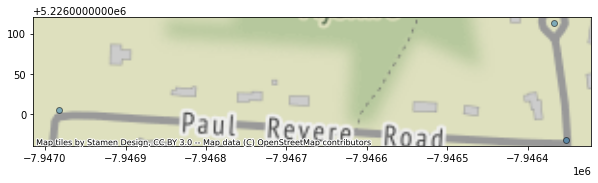

In [30]:
# see if we can do some pretty plots
import contextily as cx

#df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
#ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
q_wm = q.to_crs(epsg=3857)
buf = q_wm.buffer(500)

ax = q_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

cx.add_basemap(ax, zoom=16)

In [31]:
df_wm = df.to_crs(epsg=3857)
ax = df_wm.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax)

NameError: name 'df' is not defined

In [32]:
# get the closest UTM EPSG projection
# UTM = Universal Transverse Mercator projection; a set of projections 
# localized to different longitudes and hemishperes. The translated long lats are returned as N/E meters

utm = lonlat2UTM([q[0].x, q[0].y])
s = "EPSG:" + str(utm)
q_m = q.to_crs(s)

# q_m here is a geopandas GeoSeries. We will convert later to a numpy array.

In [33]:
s

'EPSG:32619'

In [196]:
# now have locations in meters in a local projection.

# assume that points 1 (RC) and 2 (pin) are the line, and point 1 is the 
# right side of the line (e.g. starting boats have the RC on the right)

# we need to:

# 1) transform the boat coordinates so the RC is at 0,0 and the pin is a positive x

# 2) Determine which boats are behind the line, and ahead of the line

# 3) plot the points



In [197]:
# 1) transform the boat coordinates so the RC is at 0,0 and the pin is a positive x

# create np array from Points

listarray = []
for pp in q_m:
    listarray.append([pp.x, pp.y])
q_new = np.array(listarray)

# transform RC to 0,0
q_new[:,0] = q_new[:,0] - q_m[0].x
q_new[:,1] = q_new[:,1] - q_m[0].y

print(q_new)

[[  0.           0.        ]
 [465.24967093 -40.086329  ]
 [457.47357589  67.04256408]]


In [198]:
# compute rotation angle - RC to pin...

r = np.hypot(q_new[1,0],q_new[1,1])
theta = np.arctan2(q_new[1,1],q_new[1,0])

R = rotation(theta)

# rotate the points. remember that we might be rotating the negative angle due to the order of the matrices
q_rot = np.matmul(q_new, R)

# q_rot has RC at 0,0, and pin at x = some positive value, and y = 0.
# boats with a neg y value are behind the line, and a positive value are over the line.


In [203]:
print(r,"\n\n",  q_rot)

# locations could be OK, distances look wrong...

466.97341474150727 

 [[  0.           0.        ]
 [466.97341474   0.        ]
 [450.02977413 106.06592492]]
